In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import os
import random
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix

In [2]:
def split_data(data, features, target):
    """Split on test/train/val.

    Args:
        df (pd.DataFrame): input dataset
        features (list): list of features
        target (str): target column name
    Returns:
        tuple: X_train, X_test, y_train, y_test, X_val, y_val
    """
    # Split on test/train 80/20
    # split startified on target
    X_train, X_test, y_train, y_test = train_test_split(
        data[features], data[target], test_size=0.3, random_state=1
    )
    # make validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=1
    )
    return X_train, X_test, y_train, y_test, X_val, y_val


def train_model(model, X_train, y_train, X_test, y_test, X_val, y_val):
    """Train model and return predictions.

    Args:
        model (sklearn model): model to train
        X_train (pd.DataFrame): training data
        y_train (pd.DataFrame): training labels
        X_test (pd.DataFrame): test data
        y_test (pd.DataFrame): test labels
        X_val (pd.DataFrame): validation data
        y_val (pd.DataFrame): validation labels

    Returns:
        tuple: mae, model
    """
    from sklearn.metrics import mean_absolute_error

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Evaluaate
    mae = mean_absolute_error(y_val, y_pred)
    return 


In [5]:
df = pd.read_csv('../../data/processed/cheap_features/Ant_Dem_Lif.csv')
df = df.drop('nsrrid', axis=1)
target="ahi_c0h4"

In [6]:
features = df.columns.tolist()
features.remove(target)
features

['gender',
 'race',
 'mstat',
 'hip',
 'neck20',
 'coffee15',
 'tea15',
 'soda15',
 'evsmok15',
 'smknow15',
 'asa15',
 'age_s1',
 'smokstat_s1',
 'ethnicity',
 'bmi_s1',
 'educat',
 'weight',
 'waist',
 'height',
 'weight20',
 'age_category_s1']

In [7]:
model = Ridge(alpha=4.434528937795567, random_state=1, solver='sparse_cg')

In [8]:
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

In [9]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
# Evaluaate
mae = mean_absolute_error(y_val, y_pred)

# Find out the top 5 errors

In [10]:
errors = abs(y_pred - y_val)

# Convert to DataFrame for easier analysis
error_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred, 'Error': errors})

# Sort by error to find high-error instances
high_error_df = error_df.sort_values(by='Error', ascending=False)

# Analyze high-error instances
print(high_error_df.head())

         Actual  Predicted      Error
1647  57.026239   8.634769  48.391470
2296  43.714286   5.562845  38.151441
4313  48.451327  10.983264  37.468063
1863  50.935252  13.543203  37.392049
1934  42.408875   6.112711  36.296164


# Get details of the top 5 errors

In [11]:
high_error_indices = error_df.sort_values(by='Error', ascending=False).index
original_rows = df.loc[high_error_indices]

print(original_rows.head())

      gender  race  mstat     hip  neck20  coffee15  tea15  soda15  evsmok15  \
1647     1.0   1.0    1.0  100.00    42.0       0.0    0.0     0.0       1.0   
2296     1.0   1.0    3.0  106.00    34.0       3.4    1.0     0.0       1.0   
4313     1.0   1.0    1.0  105.41    45.0      10.0    0.0     1.0       0.0   
1863     1.0   1.0    1.0  121.00    47.0       2.0    0.0     0.0       1.0   
1934     2.0   2.0    3.0  112.00    43.5       1.0    0.0     0.0       1.0   

      smknow15  ...  smokstat_s1  ethnicity     bmi_s1  educat  weight  \
1647       0.0  ...          2.0        2.0  26.964344     2.0    85.9   
2296       0.0  ...          2.0        2.0  27.372134     2.0    68.0   
4313       1.0  ...          0.0        2.0  34.907341     2.0   100.5   
1863       0.0  ...          2.0        2.0  34.622202     2.0   110.9   
1934       0.0  ...          2.0        2.0  27.331351     2.0    83.0   

       waist   height  weight20  age_category_s1   ahi_c0h4  
1647  102.00

# Plot error distribution with top 5% errors hightlighted

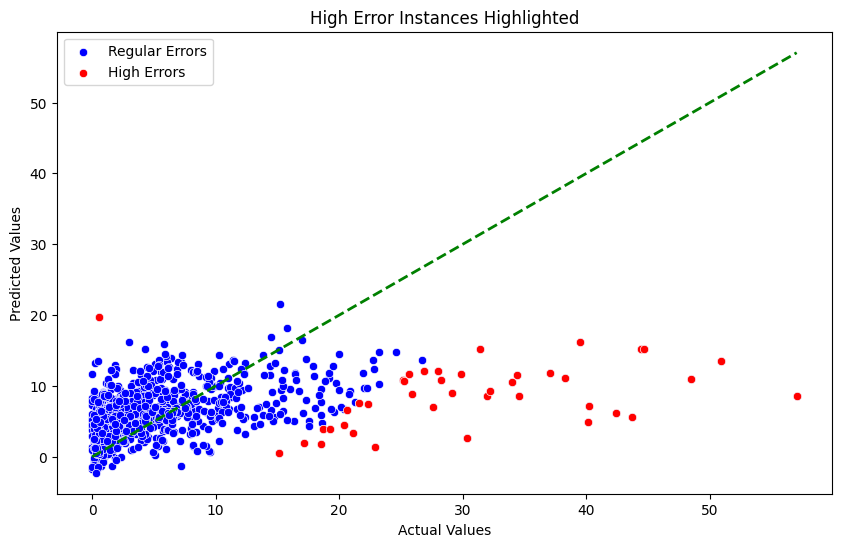

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
threshold = np.percentile(error_df['Error'], 95)
high_error_df = error_df[error_df['Error'] >= threshold]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=error_df, color='blue', label='Regular Errors')
sns.scatterplot(x='Actual', y='Predicted', data=high_error_df, color='red', label='High Errors')
plt.plot([error_df['Actual'].min(), error_df['Actual'].max()], 
         [error_df['Actual'].min(), error_df['Actual'].max()], 
         color='green', lw=2, linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('High Error Instances Highlighted')
plt.legend()
plt.show()

# Plot error distribution

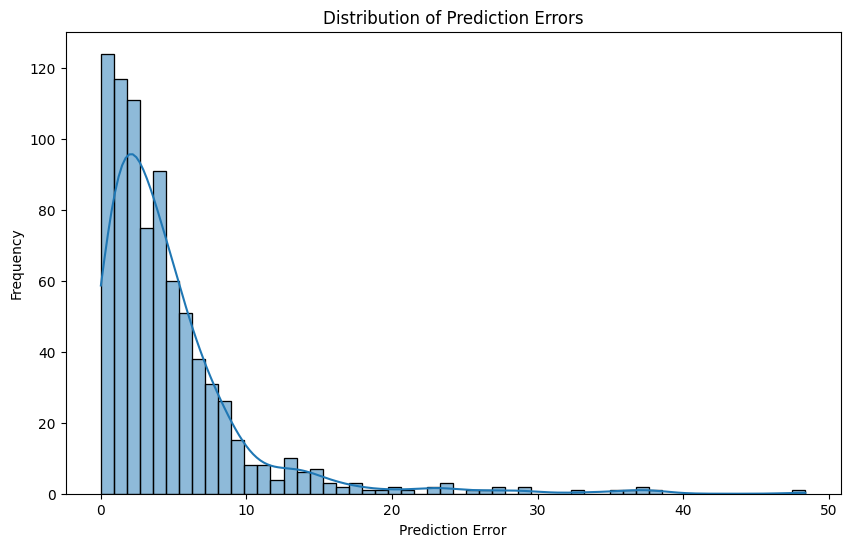

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(error_df['Error'], kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

# Examine distributions of high-error instances. Compare with the original distribution in plots.

In [14]:
high_error_data = df.loc[high_error_df.index]

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

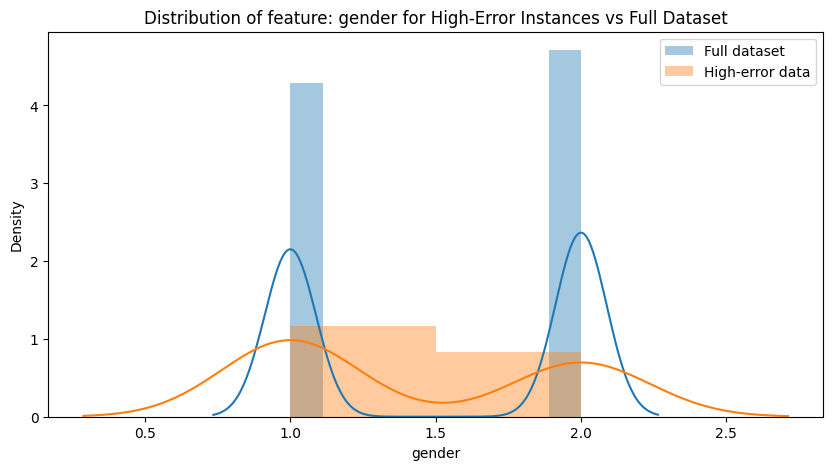

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

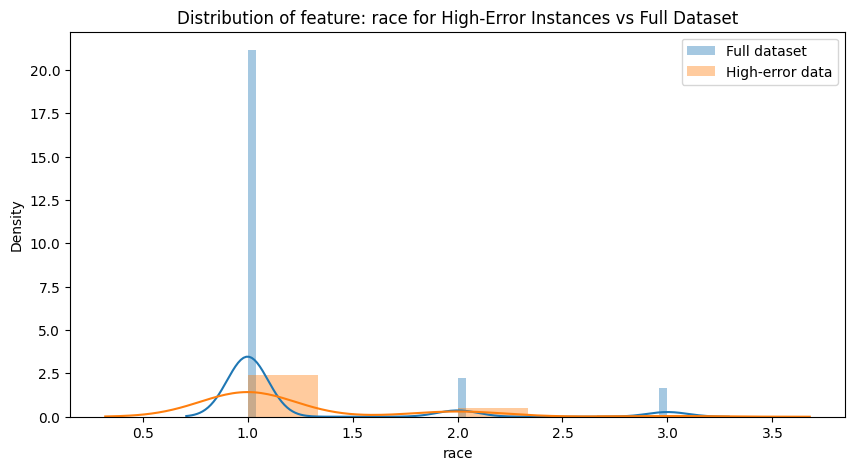

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

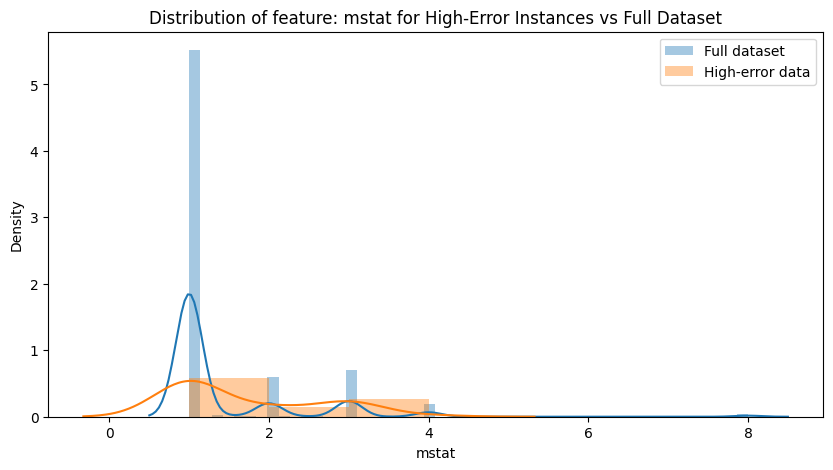

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

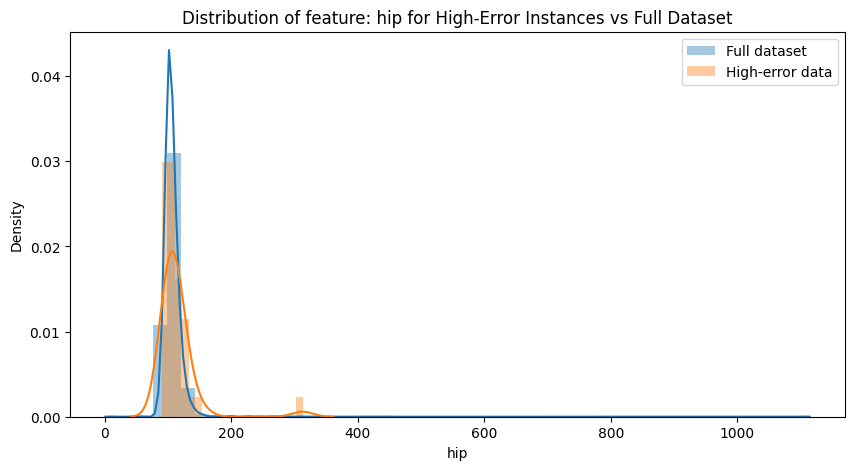

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

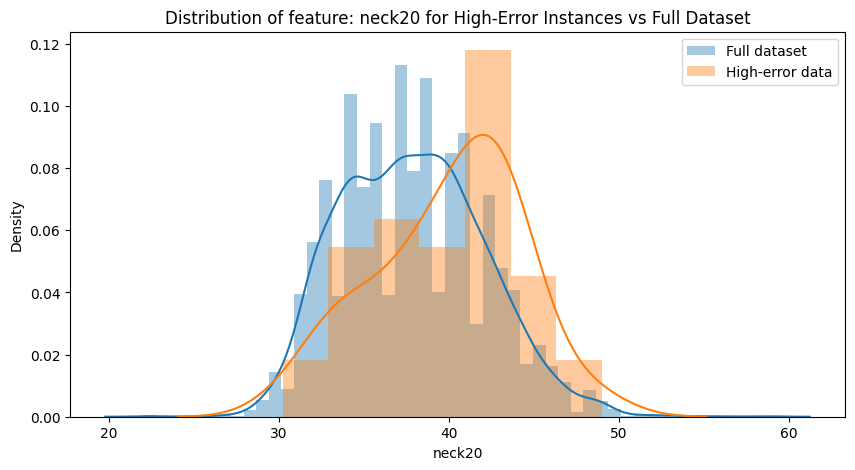

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

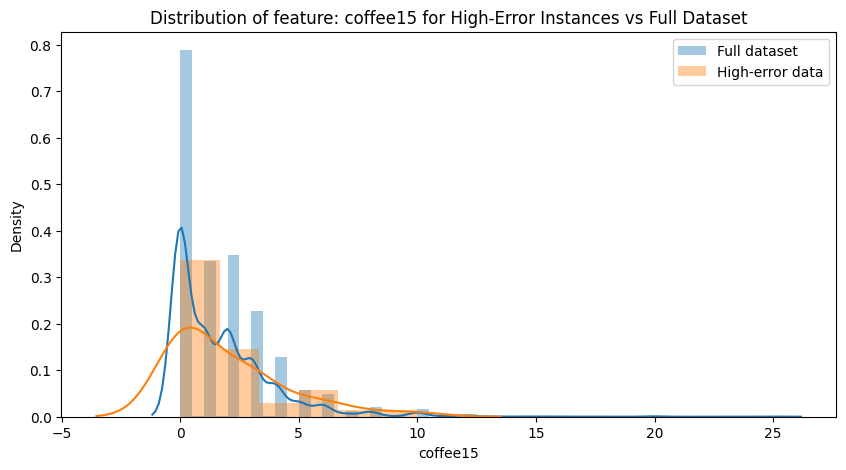

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

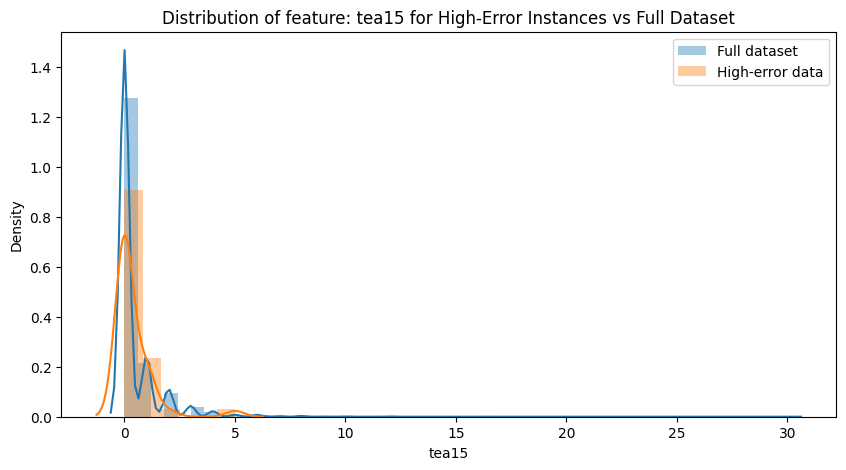

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

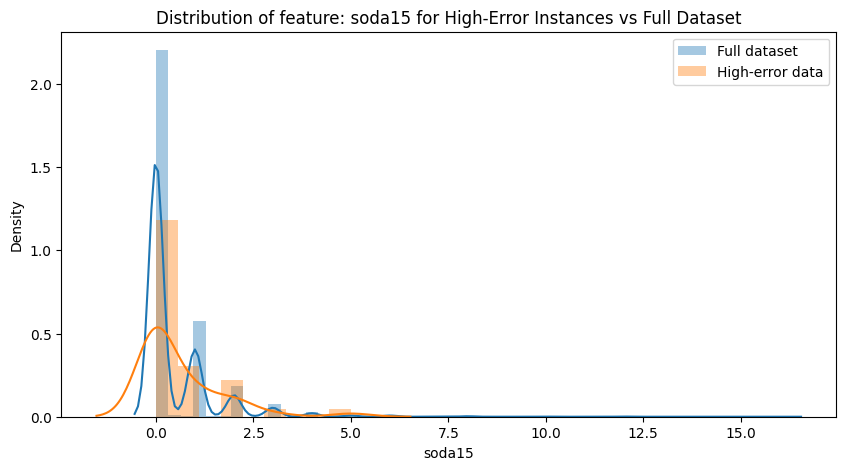

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

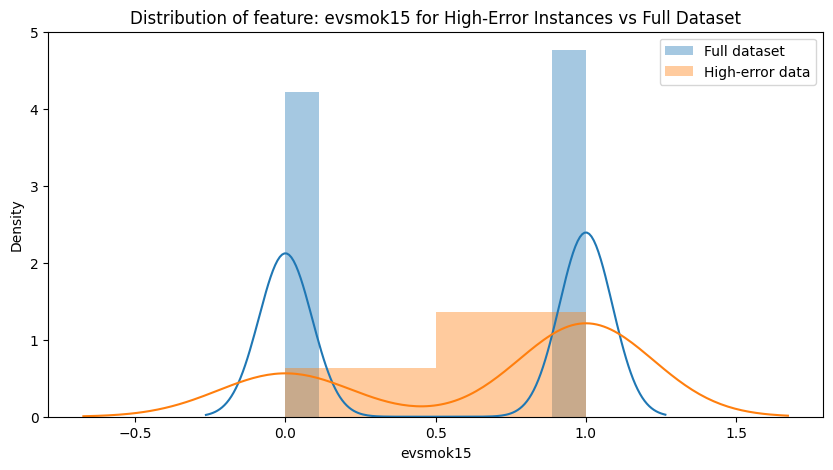

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

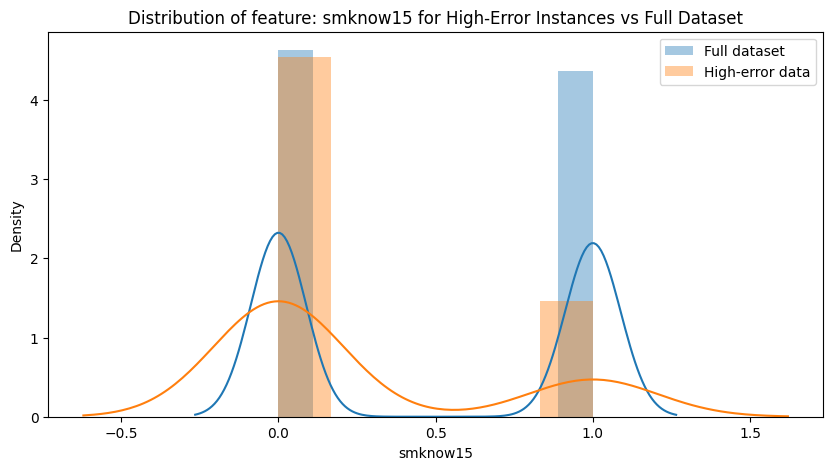

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

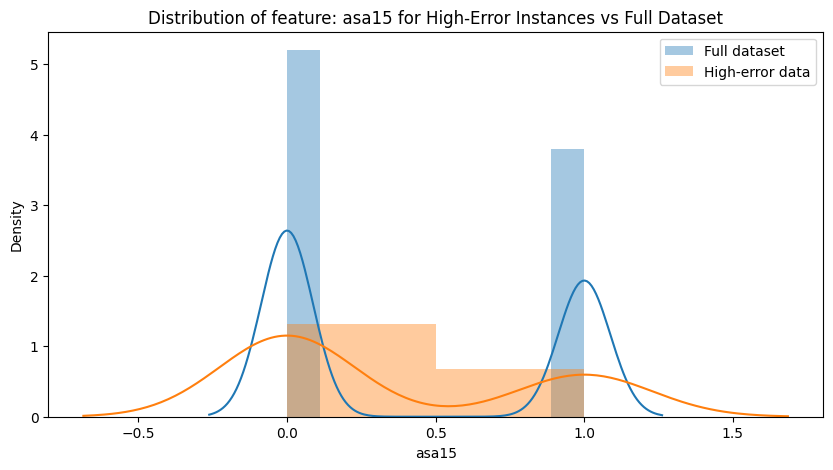

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

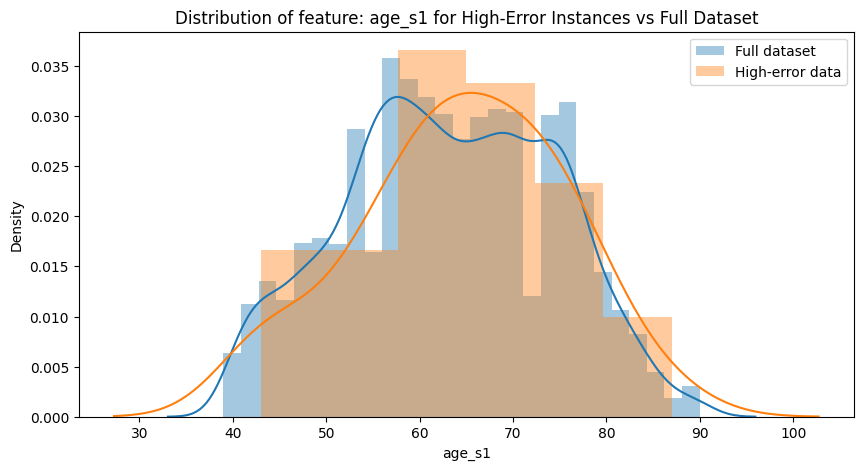

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

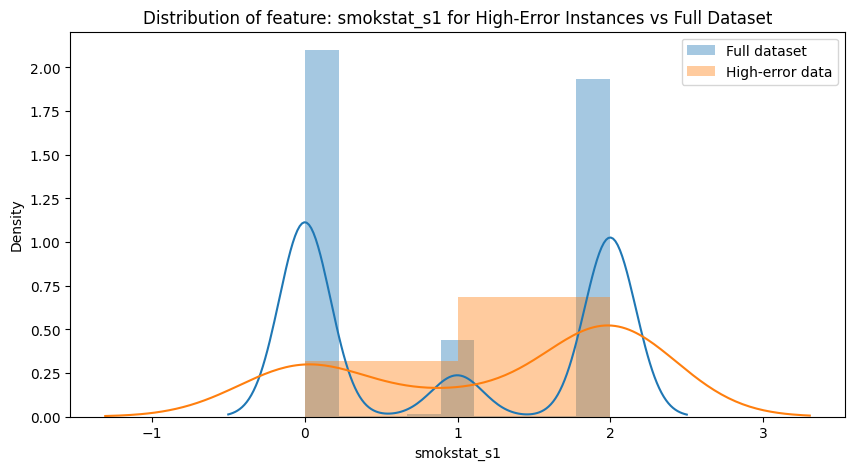

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

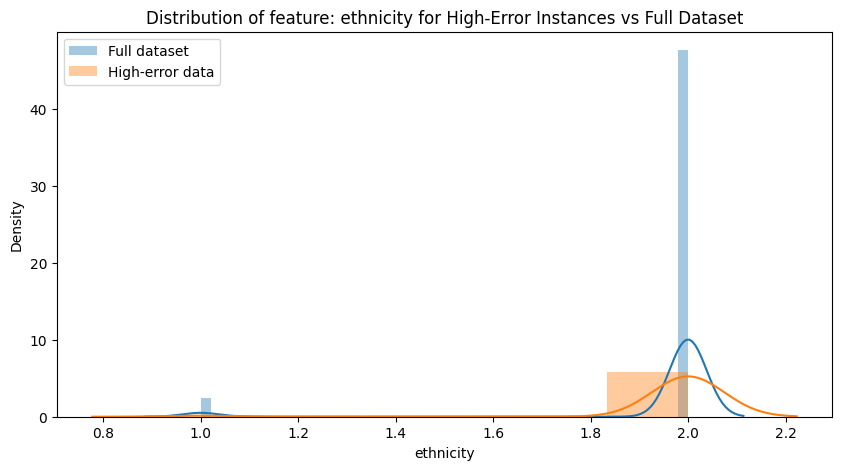

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

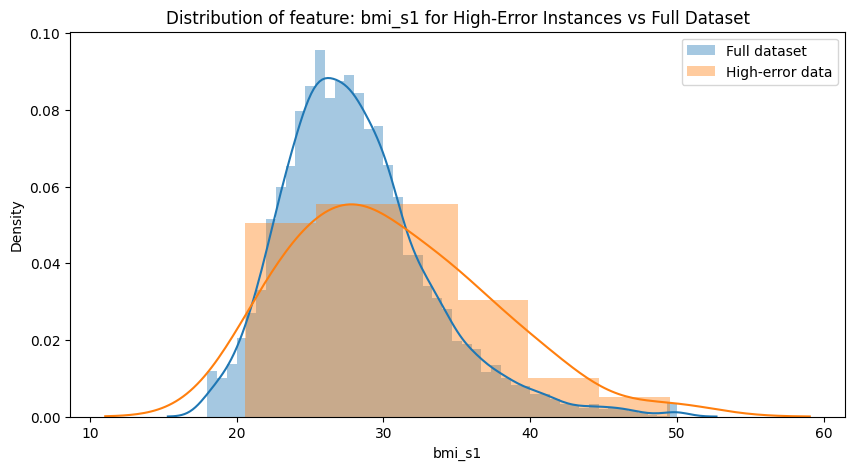

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

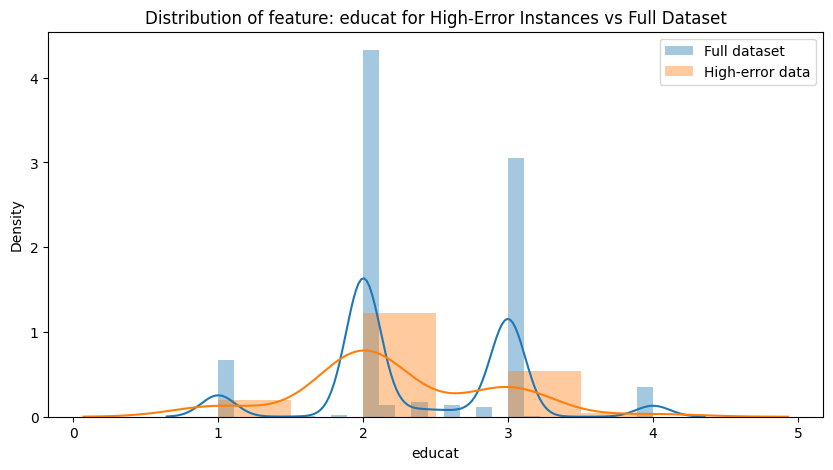

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

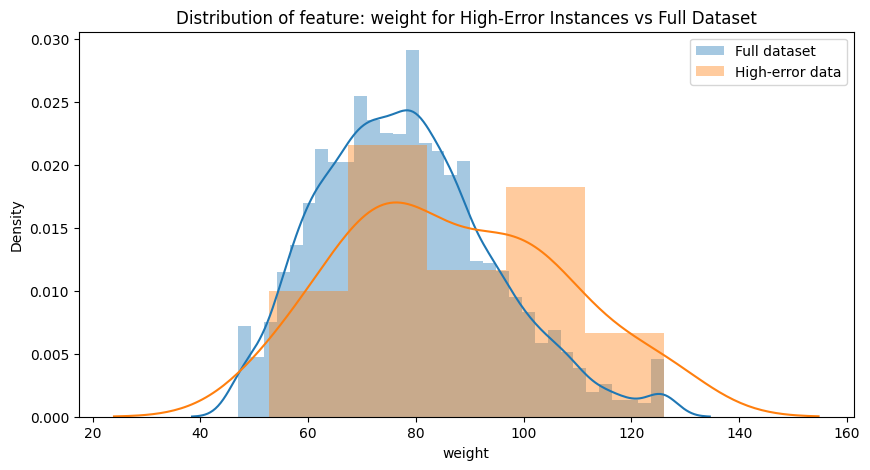

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

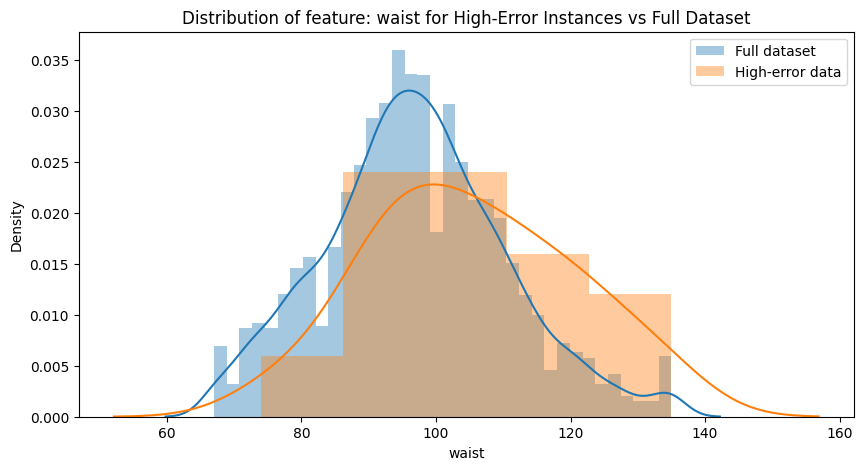

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

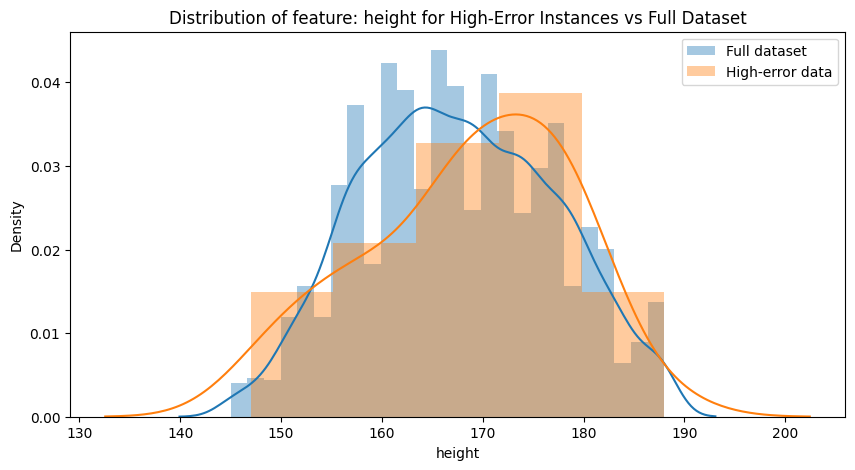

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

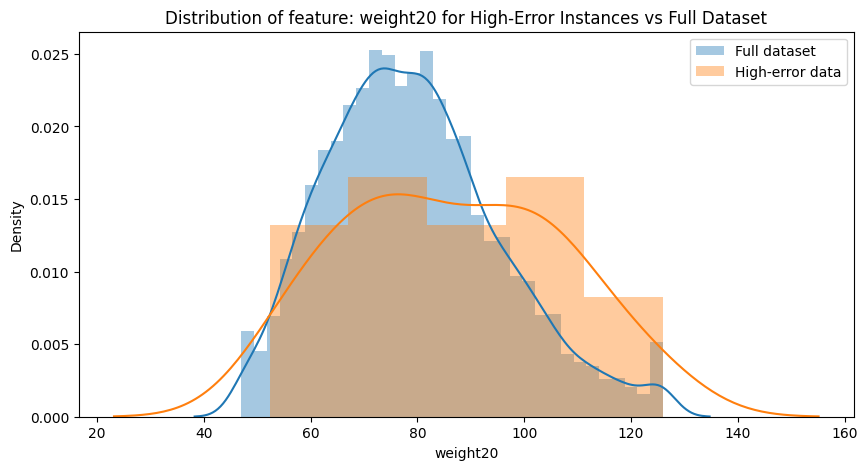

/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], label='Full dataset')
/var/folders/qn/b2l8b7c5553fly27rf2pbcm80000gn/T/ipykernel_50102/2806210837.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_e

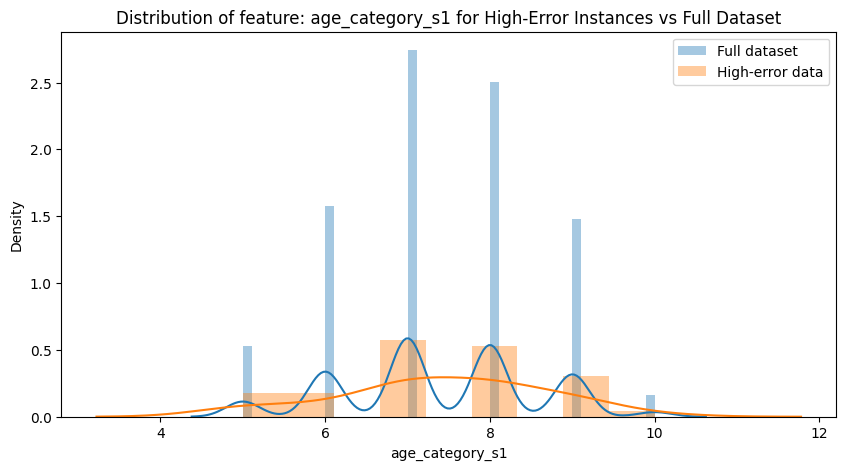

In [15]:
for column in df.columns[:-1]:  # Assuming the last column is the target
    plt.figure(figsize=(10, 5))
    sns.distplot(df[column], label='Full dataset')
    sns.distplot(high_error_data[column], label='High-error data')
    plt.legend()
    plt.title(f'Distribution of feature: {column} for High-Error Instances vs Full Dataset')
    plt.show()

# Examine high error instances with P-Value

In [16]:
from scipy.stats import ks_2samp

for column in df.columns[:-1]:  # Assuming the last column is the target
    statistic, p_value = ks_2samp(df[column], high_error_data[column])
    print(f'Feature: {column}, K-S statistic: {statistic}, P-value: {p_value}')

Feature: gender, K-S statistic: 0.10897026440974265, P-value: 0.6782768809134841
Feature: race, K-S statistic: 0.041426434250558905, P-value: 0.9999977237881653
Feature: mstat, K-S statistic: 0.19581953572809332, P-value: 0.0764339280873627
Feature: hip, K-S statistic: 0.1525314753492125, P-value: 0.2709824286126146
Feature: neck20, K-S statistic: 0.28340841471819267, P-value: 0.0021876902615378174
Feature: coffee15, K-S statistic: 0.10275924089358054, P-value: 0.7444611111991449
Feature: tea15, K-S statistic: 0.05666403321510817, P-value: 0.998498659206252
Feature: soda15, K-S statistic: 0.06683784101796911, P-value: 0.9876277675925582
Feature: evsmok15, K-S statistic: 0.1529475046645711, P-value: 0.2681423146894572
Feature: smknow15, K-S statistic: 0.24162478358070968, P-value: 0.014100463417279878
Feature: asa15, K-S statistic: 0.08100384932174615, P-value: 0.9322414875097285
Feature: age_s1, K-S statistic: 0.10849540266594947, P-value: 0.6834208327828659
Feature: smokstat_s1, K-S s